<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/Predict_DualLTSM_Technical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!pip install keras-tqdm
!mkdir "drive/My Drive/FintechData/Test"

TensorFlow 1.x selected.
mkdir: cannot create directory ‘drive/My Drive/FintechData/Test’: File exists


In [2]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from sklearn import preprocessing
import numpy as np
import datetime as dt
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from keras_tqdm import TQDMNotebookCallback

history_points = 60
np.random.seed(4)

sns.set()
sns.set(rc={'figure.figsize':(20,8)})
sns.set(font_scale=1.2)

data_folder = "drive/My Drive/FintechData/" + str(dt.date.today())

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [15]:
def create_dataset(ticker):
    end_date = dt.date.today()
    start_date = end_date - dt.timedelta(365 * 20)
    data = pdr.get_data_yahoo(ticker, start_date, end_date)
    data.reset_index(inplace=True)
    data.rename(columns={'Open': 'open',
                         'High': 'high',
                         'Low': 'low',
                         'Close': 'close',
                         'Volume': 'volume'},
                inplace=True)
    HIGH = 0
    LOW = 1
    OPEN = 2
    CLOSE = 3

    dates = data.Date.values
    prices = data['open'].values
    data.drop(columns=['Date', 'Adj Close'], inplace=True)
    data = data.values

    """
    prices_open = data['open'].values
    prices_high = data['high'].values
    prices_low = data['low'].values
    prices_close = data['close'].values
    volume = data['volume'].values

    open_normalizer = preprocessing.MinMaxScaler()
    open_normalised = open_normalizer.fit_transform(prices.reshape(len(data), -1))

    high_normalizer = preprocessing.MinMaxScaler()
    high_normalised = open_normalizer.fit_transform(prices_high.reshape(len(data), -1))

    low_normalizer = preprocessing.MinMaxScaler()
    low_normalised = open_normalizer.fit_transform(prices_low.reshape(len(data), -1))

    close_normalizer = preprocessing.MinMaxScaler()
    close_normalised = open_normalizer.fit_transform(prices_close.reshape(len(data), -1))

    vol_normalizer = preprocessing.MinMaxScaler()
    vol_normalised = open_normalizer.fit_transform(volume.reshape(len(data), -1))
    data_normalised = np.concatenate((open_normalised, high_normalised, low_normalised, close_normalised, vol_normalised), axis=1)
    print(prices[-10:])
    print(open_normalised[-10:])
    print(_data_normalised[-10:])
    """

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    
    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_values_normalised = np.array([data_normalised[:, OPEN][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_values_normalised = np.expand_dims(next_day_values_normalised, -1)

    next_day_values = np.array([data[:, OPEN][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_values = np.expand_dims(next_day_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_values)

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))
        #technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    dates = dates[-ohlcv_histories_normalised.shape[0]:]
    prices = prices[-ohlcv_histories_normalised.shape[0]:]
    assert ohlcv_histories_normalised.shape[0] == next_day_values_normalised.shape[0] 
    assert ohlcv_histories_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return (ohlcv_histories_normalised,
            technical_indicators_normalised,
            next_day_values_normalised,
            next_day_values,
            y_normaliser,
            prices,
            dates)

In [5]:
def build_test_train_data(ohlcv_histories, 
                          technical_indicators, 
                          next_day_values,
                          unscaled_y,
                          prices,
                          dates):
    test_split = 0.9
    n = int(ohlcv_histories.shape[0] * test_split)

    ohlcv_train = ohlcv_histories[:n]
    tech_ind_train = technical_indicators[:n]
    y_train = next_day_values[:n]

    ohlcv_test = ohlcv_histories[n:]
    tech_ind_test = technical_indicators[n:]
    y_test = next_day_values[n:]
    unscaled_y_test = unscaled_y[n:]
    prices_test = prices[n:]
    dates_test = dates[n:]

    return (ohlcv_train, 
            tech_ind_train, 
            y_train,
            ohlcv_test,
            tech_ind_test,
            y_test,
            unscaled_y_test,
            prices_test,
            dates_test)


In [43]:
def build_train_model(ticker,
                      ohlcv_train,
                      tech_ind_train,
                      y_train,
                      history_points, 
                      technical_indicators):
    # model architecture

    maybe_make_dir(data_folder)
    model_name = data_folder + "/technical_model_" + ticker + ".h5"

    if (os.path.exists(model_name)):
        return keras.models.load_model(model_name)
    
    # define two sets of inputs
    lstm_input = Input(shape=(history_points, 5), name='lstm_input')
    dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

    # the first branch operates on the first input
    x = CuDNNLSTM(200, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    lstm_branch = Model(inputs=lstm_input, outputs=x)

    # the second branch opreates on the second input
    y = Dense(50, name='tech_dense_0')(dense_input)
    y = Activation("relu", name='tech_relu_0')(y)
    y = Dropout(0.2, name='tech_dropout_0')(y)
    technical_indicators_branch = Model(inputs=dense_input, outputs=y)

    # combine the output of the two branches
    combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

    z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
    z = Dense(1, activation="linear", name='dense_out')(z)

    # our model will accept the inputs of the two branches and
    # then output a single value
    model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
    adam = optimizers.Adam(lr=0.0005)
    model.compile(optimizer=adam, loss='mse')
    model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=100, shuffle=True, validation_split=0.1, verbose=0, callbacks=[TQDMNotebookCallback()])
    print ("Save Model at:" + model_name)
    model.save(model_name)
    return model


def predict_test_data(model,
                      ohlcv_test,
                      tech_ind_test,
                      unscaled_y_test,
                      y_normaliser):
    y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
    y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
    assert unscaled_y_test.shape == y_test_predicted.shape
    real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
    scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
    print("MSE: Real:{0} Scaled:{1}".format(real_mse, scaled_mse))
    return y_test_predicted


def calculate_accuracy(unscaled_y_test, 
                       y_test_predicted, 
                       dates_test,
                       time_span, 
                       start=0, 
                       end=-1):
    result = pd.DataFrame(np.concatenate((unscaled_y_test[start:end], y_test_predicted[start:end]), axis=1),
                          columns=['real', 'pred'], 
                          index=dates_test[:-1])
    portfolio = result.copy()
    result['sig_real'] = result.real.pct_change()
    result['sig_pred'] = result.pred.pct_change()
    result['corr'] = np.sign(1 + np.sign(result.sig_real * result.sig_pred))
    result.dropna(inplace=True)

    portfolio = portfolio[['real', 'pred']]
    portfolio['real_chg'] = portfolio.real.pct_change()
    portfolio['pred_chg'] = portfolio.pred.pct_change()
    portfolio.dropna(inplace=True)
    portfolio['long_trade'] = np.sign(np.sign(portfolio.pred_chg) + 1) * portfolio.real_chg
    portfolio['short_trade'] = np.sign(np.sign(portfolio.pred_chg) - 1) * portfolio.real_chg
    portfolio['base_profit'] = portfolio.real_chg.cumsum()
    portfolio['long_profit'] = portfolio.long_trade.cumsum()
    portfolio['short_profit'] = portfolio.short_trade.cumsum()
    portfolio['all_profit'] = portfolio.long_profit + portfolio.short_profit

    long_profits = []
    all_profits = []
    short_profits = []
    base_profits = []
    for i in tqdm(range(len(portfolio) - time_span)):
        porfolio_span = portfolio[i:i+time_span][['real_chg', 'pred_chg', 'long_trade', 'short_trade']]
        porfolio_span['base_profit'] = porfolio_span.real_chg.cumsum()
        porfolio_span['long_profit'] = porfolio_span.long_trade.cumsum()
        porfolio_span['short_profit'] = porfolio_span.short_trade.cumsum()
        porfolio_span['all_profit'] = porfolio_span.long_profit + porfolio_span.short_profit
        last_row = porfolio_span.tail(1).values
        base_profits.append(last_row[0][-4])
        long_profits.append(last_row[0][-3])
        short_profits.append(last_row[0][-2])
        all_profits.append(last_row[0][-1])

    portfolio_over_times = pd.DataFrame({'Base Profit':base_profits, 
                                         'Long Profit':long_profits, 
                                         'Short Profit':short_profits,
                                         'All Profit':all_profits},
                                        index=dates_test[-len(base_profits):])
    return result, portfolio, portfolio_over_times


## Build, Train Model
## Calculate Result

In [39]:
ticker = "^IXIC" #@param ["^GSCP", "^IXIC", "^DJI", "^VIX", "MSFT", "QCOM", "GE"]
time_span = 6 #@param {type:"slider", min:1, max:12, step:1}
time_span *= 21

In [44]:
ohlcv_histories, technical_indicators, next_day_values, unscaled_y, y_normaliser, prices, dates = create_dataset(ticker)

# Build train and test data for both ohlcv and technical indicator
ohlcv_train, tech_ind_train, y_train, ohlcv_test, tech_ind_test, y_test, unscaled_y_test, prices_test, dates_test = \
build_test_train_data(ohlcv_histories=ohlcv_histories, 
                      technical_indicators=technical_indicators, 
                      next_day_values=next_day_values,
                      unscaled_y=unscaled_y,
                      prices=prices,
                      dates=dates)

# Build Model and train with train data
model = build_train_model(ticker=ticker,
                          ohlcv_train=ohlcv_train,
                          tech_ind_train=tech_ind_train,
                          y_train=y_train,
                          history_points=history_points, 
                          technical_indicators=technical_indicators)

# Build a predict price for test data
y_test_predicted = predict_test_data(model=model, 
                  ohlcv_test=ohlcv_test, 
                  tech_ind_test=tech_ind_test,
                  unscaled_y_test=unscaled_y_test,
                  y_normaliser=y_normaliser)

# Calculate and plot accuracy metrics
result, portfolio, portfolio_over_time = calculate_accuracy(unscaled_y_test=unscaled_y_test,
                                                            y_test_predicted=y_test_predicted,
                                                            dates_test=dates_test,
                                                            time_span=time_span)

Train shape:(4471, 60, 5)
Test  shape:(497, 60, 5)
MSE: Real:123603.39414392918 Scaled:3266.2414020667507


## Predict Result

In [45]:
display(result)

,real,pred,sig_real,sig_pred,corr
2018-07-02,7451.899902,7307.256348,-0.012225,0.005432,0.0
2018-07-03,7593.629883,7322.881348,0.019019,0.002138,1.0
2018-07-05,7550.660156,7354.232910,-0.005659,0.004281,0.0
2018-07-06,7595.930176,7342.147949,0.005996,-0.001643,0.0
2018-07-09,7731.740234,7431.743652,0.017879,0.012203,1.0
...,...,...,...,...,...
2020-06-12,9715.870117,8852.648438,-0.007698,-0.037398,1.0
2020-06-15,9426.900391,8950.436523,-0.029742,0.011046,0.0
2020-06-16,9949.780273,8930.436523,0.055467,-0.002235,0.0
2020-06-17,9943.309570,9136.630859,-0.000650,0.023089,0.0


In [46]:
print("Train Records:" + str(y_train.shape[0]))
print("Test  Records:" + str(y_test.shape[0]))
print("Accuracy:{0:6.2f}".format(result['corr'].sum() * 100/len(result)))
last_row = portfolio.tail(1).values
print("Profit:\n\tBase:{0:6.3f}\n\tLong:{1:6.3f}\n\tShort:{2:6.3f}\n\tAll:{3:6.3f}".
        format(last_row[0][-4], last_row[0][-3], last_row[0][-2], last_row[0][-1]))



Train Records:4471
Test  Records:497
Accuracy: 61.01
Profit:
	Base: 0.329
	Long: 1.141
	Short: 0.812
	All: 1.953


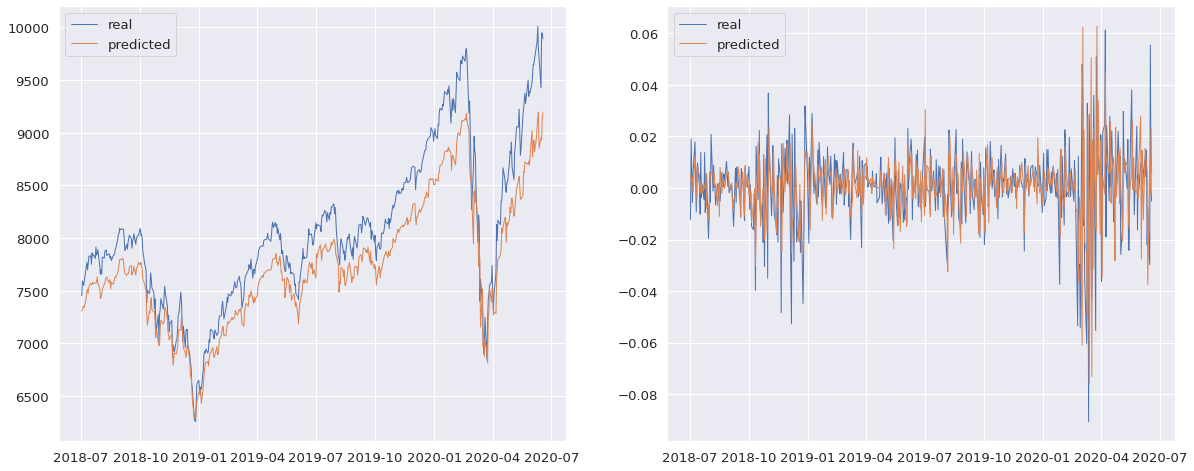

In [47]:
fig, axs = plt.subplots(1,2)

axs[0].plot(result.real, label='real', linewidth=1)
axs[0].plot(result.pred, label='predicted', linewidth=1)
axs[0].legend()
#axs[0].title("Price Comparision")
#plt.show()


axs[1].plot(result.sig_real, label='real', linewidth=1)
axs[1].plot(result.sig_pred, label='predicted', linewidth=1)
axs[1].legend()
#axs[1].title("Daily Return Comparision")
plt.show()

# Profits and Trading

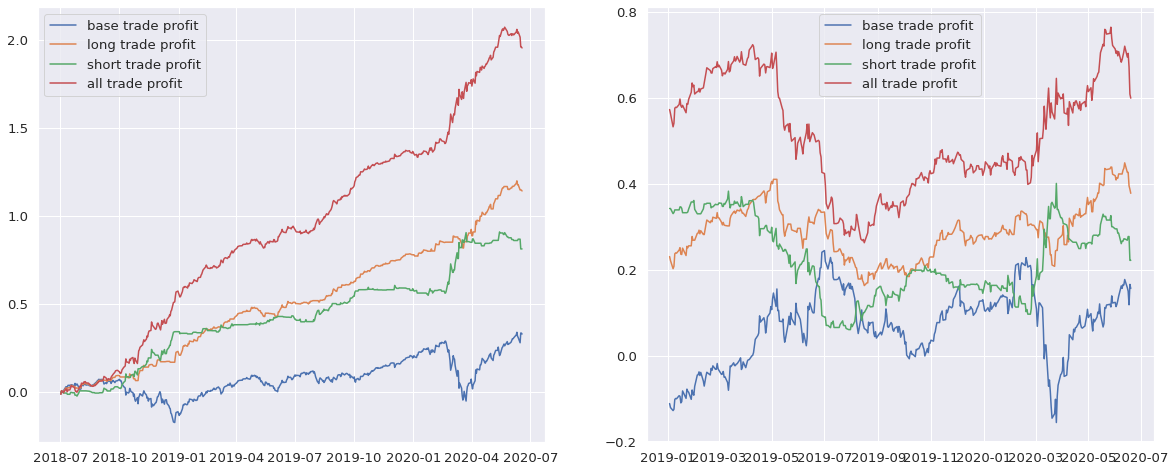

In [48]:
fig, axs = plt.subplots(1,2)
axs[0].plot(portfolio['base_profit'], label='base trade profit')
axs[0].plot(portfolio['long_profit'], label='long trade profit')
axs[0].plot(portfolio['short_profit'], label='short trade profit')
axs[0].plot(portfolio['all_profit'], label='all trade profit')
axs[0].legend()

axs[1].plot(portfolio_over_time['Base Profit'], label='base trade profit')
axs[1].plot(portfolio_over_time['Long Profit'], label='long trade profit')
axs[1].plot(portfolio_over_time['Short Profit'], label='short trade profit')
axs[1].plot(portfolio_over_time['All Profit'], label='all trade profit')
axs[1].legend()
plt.show()


## Profit Statistics

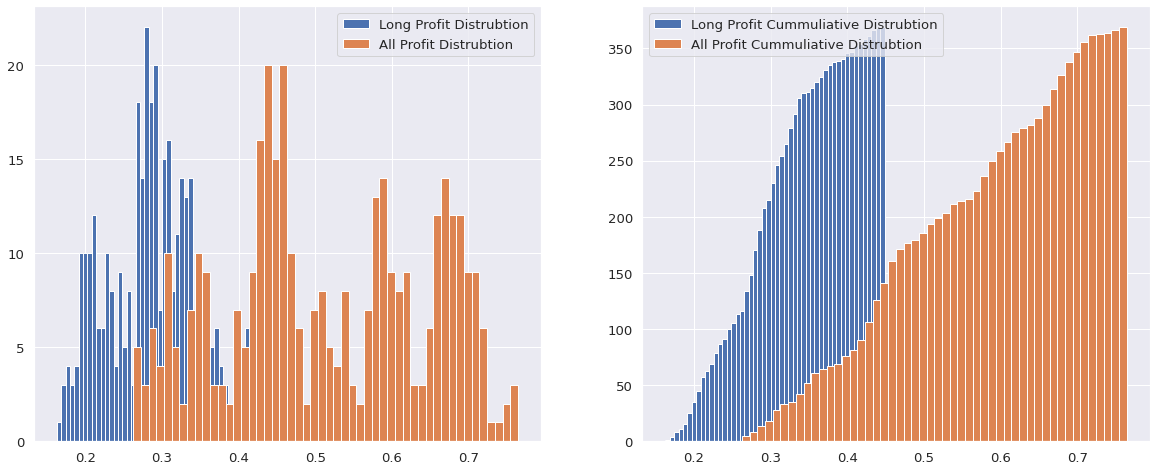

In [49]:
fig, axs = plt.subplots(1,2)
axs[0].hist(portfolio_over_time['Long Profit'], bins=50, label="Long Profit Distrubtion")
axs[0].hist(portfolio_over_time['All Profit'], bins=50, label="All Profit Distrubtion")
axs[0].legend()

axs[1].hist(portfolio_over_time['Long Profit'], bins=50, cumulative=True, label="Long Profit Cummuliative Distrubtion")
axs[1].hist(portfolio_over_time['All Profit'], bins=50, cumulative=True, label="All Profit Cummuliative Distrubtion")
axs[1].legend()
plt.show()

In [34]:
display(portfolio_over_time.describe())

,Base Profit,Long Profit,Short Profit,All Profit
count,243.000000,243.000000,243.000000,243.000000
mean,0.141196,0.550448,0.409513,0.959961
std,0.108722,0.070424,0.094856,0.127184
min,-0.102055,0.413240,0.209543,0.705686
25%,0.044739,0.497649,0.371599,0.897361
50%,0.125979,0.534081,0.441397,0.960322
75%,0.239592,0.584773,0.479679,1.040709
max,0.371742,0.737240,0.553184,1.217187


# Last Code

In [63]:
def calculate_all_earning(ticker,
                          ohlcv_test,
                          predicted_prices,
                          prices_test,
                          dates_test,
                          y_normaliser,
                          time_span,
                          investment=100000):
    def calculate_earning(use_short=False, start=0, end=-1, verbose=0):
        thresh = 0
        LONG = 1
        SHORT = -1
        NO_TRADE = 0
        trade_str = {LONG:"Long ", SHORT:"Short"}
        balance = investment
        signal = NO_TRADE
        predict_price_today = -1
        yesterday_price = -1

        stock = 0
        buy_sell_price = 0
        lost_days = 0
        trading_days = 0

        balances = []
        open_prices = []
        labels = []
        open_price = 0

        log_trade = start==0 and end==-1 and not use_short

        if log_trade:
            log_file = open(data_folder + "/trade_log_" + ticker + ".txt", "w")

        #if end == -1:
        #    print(ohlcv_test[-1][-10:])

        for ohlcv, predicted_price, price, date in zip(ohlcv_test[start: end], 
                                                       predicted_prices[start:end],
                                                       prices_test[start:end],
                                                       dates_test[start:end]):
            normalised_price_today = ohlcv[-1][2]
            normalised_price_today = np.array([[normalised_price_today]])
            price_today = y_normaliser.inverse_transform(normalised_price_today)
            open_price = price_today[0][0]
            #open_price = price
            #print(price)
            if predict_price_today != -1:
                today_profit = stock * signal * (open_price - buy_sell_price)
                if signal != NO_TRADE:
                    trading_days += 1   
                    if today_profit < 0:
                        lost_days += 1
                balance += (stock * signal * open_price)
                if stock != 0 and log_trade:
                    date_str = np.datetime_as_string(date, unit='D')
                    log_file.write(f"{date_str}\t{trade_str.get(signal)}\tPrice:{price[0]:.3f}\tTrade:[{buy_sell_price:.3f},{open_price:.3f}]\tBalance:{balance:.3f}\tProfit:{today_profit:.3f}\n")
                open_prices.append(open_price)
                balances.append(balance)
                stock = int(balance / open_price)
                delta = (predicted_price - predict_price_today) / predict_price_today
                if delta > thresh:
                    signal = LONG
                elif use_short and delta < -thresh:
                    signal = SHORT
                else:
                    signal = NO_TRADE
                labels.append(signal)
                buy_sell_price = open_price
                balance -= (stock * signal * open_price)
            predict_price_today = predicted_price
        balance += (stock * signal * open_price)
        profit = (balance - investment)*100 / investment
        base_profit = (open_prices[-1] - open_prices[0])*100 / open_prices[0]
        if verbose > 0:
            print("Short Trading:{0}, Profit:{1:6.2f} Base:{2:6.2f} Period:[{3}, {4}] Lost:{5:6.2f}".
                format(int(use_short), 
                        profit, base_profit,
                        start, end, lost_days*100 / trading_days))
        if log_trade:
            log_file.close()
        return open_prices, balances, labels, profit, base_profit

    long_profits = []
    long_short_profits = []
    base_profits = []
    prices, long_balances, long_labels, _, _ = calculate_earning(use_short=False, start=0, end=-1, verbose=1)
    _, long_short_balances, long_short_labels, _, _ = calculate_earning(use_short=True, start=0, end=-1, verbose=1)
    if time_span != 0:
        for i in tqdm(range(0, unscaled_y_test.shape[0] - time_span)):
            _, _, _, long_profit, base_profit = calculate_earning(use_short=False, start=i, end=i+time_span, verbose=0)
            _, _, _, long_short_profit, _ = calculate_earning(use_short=True, start=i, end=i+time_span, verbose=0)
            long_profits.append(long_profit)
            long_short_profits.append(long_short_profit)
            base_profits.append(base_profit)
    return prices, long_balances, long_labels, long_profits, long_short_balances, long_short_labels, long_short_profits, base_profits

In [59]:
def get_price_prediction(ohlcv_test, 
                         tech_ind_test,
                         model,
                         y_normaliser):
    predicted_prices = []
    today_prices = []
    predicted_prices.append(-1)
    for ohlcv, ind in zip(ohlcv_test, tech_ind_test):
        normalised_price_today = ohlcv[-1][2]
        normalised_price_today = np.array([[normalised_price_today]])
        today_price = y_normaliser.inverse_transform(normalised_price_today)
        today_prices.append(today_price)
        predicted_price = np.squeeze(y_normaliser.inverse_transform(model.predict([[ohlcv], [ind]])))
        predicted_prices.append(predicted_price)

    return today_prices, predicted_prices[:-1]


def build_portfolio(ticker,
                    ohlcv_test, 
                    tech_ind_test,
                    prices_test,
                    dates_test, 
                    model, 
                    y_normaliser, 
                    time_span):
    today_prices, predicted_prices = get_price_prediction(ohlcv_test=ohlcv_test, 
                                            tech_ind_test=tech_ind_test,
                                            model=model, 
                                            y_normaliser=y_normaliser)
    prices, long_balances, long_labels, long_profits, long_short_balances, long_short_labels, long_short_profits, base_profits = \
        calculate_all_earning(ticker=ticker,
                              ohlcv_test=ohlcv_test,
                              prices_test=prices_test,
                              dates_test=dates_test,
                              predicted_prices=predicted_prices,
                              y_normaliser=y_normaliser,
                              time_span=time_span)
    portfolio = pd.DataFrame(np.vstack((prices, long_balances, long_short_balances)).T,
                      columns=['base', 'profit_long', 'profit_long_short'],
                      index=dates_test[-len(prices):])
    portfolio_cpy = portfolio.copy()
    portfolio /= portfolio.iloc[0]
    portfolio -= 1

    plt.plot(prices)
    plt.plot(prices_test[1:])
    plt.show()

    fig, axs = plt.subplots(1,2)
    axs[0].plot(portfolio.index, portfolio.base, label='Base Profit', linewidth=1)
    axs[0].plot(portfolio.index, portfolio.profit_long, label='Long Trade Profit', linewidth=1)
    axs[0].plot(portfolio.index, portfolio.profit_long_short, label='Long/Short Trade Profit', linewidth=1)
    axs[0].legend()
    #axs[0].title("Profits vs. Close Price")
    #plt.show()

    axs[1].plot(dates_test[-len(long_profits):], base_profits, label='Base Profits', linewidth=1)
    axs[1].plot(dates_test[-len(long_profits):], long_profits, label='Long Trade Profit', linewidth=1)
    axs[1].plot(dates_test[-len(long_profits):], long_short_profits, label='Long/Short Trade Profit', linewidth=1)
    axs[1].legend()
    #axs[1].title("Profits over " + str(time_span) + " days")
    plt.show()

    print("\n")
    portfolio_cpy['signal_long'] = np.array(long_labels)
    portfolio_cpy['signal_long_short'] = np.array(long_short_labels)
    plt.plot(portfolio.index, portfolio_cpy.base, label='Price', linewidth=1)
    # Plot the buy signals
    plt.plot(portfolio_cpy.loc[portfolio_cpy.signal_long_short == 1].index, 
                portfolio_cpy.base[portfolio_cpy.signal_long == 1],
                'o', markersize=5, color='g', label="Long")
    # Plot the buy signals
    plt.plot(portfolio_cpy.loc[portfolio_cpy.signal_long_short == -1].index, 
                portfolio_cpy.base[portfolio_cpy.signal_long_short == -1],
                'o', markersize=5, color='r', label="Short")
    plt.legend()
    plt.title("Trade History")
    plt.show()

    print("\n")
    profit_df = pd.DataFrame(np.vstack((long_profits, long_short_profits)).T,
                        columns=['profit_long', 'profit_long_short'],
                        index=dates_test[-len(long_profits):])

    fig, axs = plt.subplots(1,2)
    axs[0].hist(profit_df.profit_long, bins=50, label="Long Profit Distrubtion")
    axs[0].hist(profit_df.profit_long_short, bins=50, label="Long/Short Profit Distrubtion")
    axs[0].legend()

    axs[1].hist(profit_df.profit_long, bins=50, cumulative=True, label="Long Profit Cummuliative Distrubtion")
    axs[1].hist(profit_df.profit_long_short, bins=50, cumulative=True, label="Long/Short Profit Cummuliative Distrubtion")
    axs[1].legend()
    plt.show()
    display(profit_df.describe())
    

In [66]:
# Create histroical data and technical indictaore
# Normilize data and build set of winodws data
ohlcv_histories, technical_indicators, next_day_values, unscaled_y, y_normaliser, prices, dates = create_dataset(ticker)

# Build train and test data for both ohlcv and technical indicator
ohlcv_train, tech_ind_train, y_train, ohlcv_test, tech_ind_test, y_test, unscaled_y_test, prices_test, dates_test = \
build_test_train_data(ohlcv_histories=ohlcv_histories, 
                      technical_indicators=technical_indicators, 
                      next_day_values=next_day_values,
                      unscaled_y=unscaled_y,
                      prices=prices,
                      dates=dates)

# Build Model and train with train data
model = build_train_model(ticker=ticker,
                          ohlcv_train=ohlcv_train,
                          tech_ind_train=tech_ind_train,
                          y_train=y_train,
                          history_points=history_points, 
                          technical_indicators=technical_indicators)

# Build a predict price for test data
y_test_predicted = predict_test_data(model=model, 
                  ohlcv_test=ohlcv_test, 
                  tech_ind_test=tech_ind_test,
                  unscaled_y_test=unscaled_y_test,
                  y_normaliser=y_normaliser)

# Calculate and plot accuracy metrics
calculate_accuracy(unscaled_y_test=unscaled_y_test,
                   y_test_predicted=y_test_predicted,
                   prices_test=prices_test,
                   dates_test=dates_test)



Train shape:(4471, 60, 5)
Test  shape:(497, 60, 5)
MSE: Real:123603.39414392918 Scaled:3266.2414020667507


ValueError: ignored

In [ ]:
# Build Portfolio
#predicted_prices, today_prices = get_price_prediction(ohlcv_test=ohlcv_test, 
#                                        tech_ind_test=tech_ind_test,
#                                        model=model, 
#                                        y_normaliser=y_normaliser)

build_portfolio(ticker=ticker,
                ohlcv_test=ohlcv_test,
                tech_ind_test=tech_ind_test,
                prices_test=unscaled_y_test,
                dates_test=dates_test,
                y_normaliser=y_normaliser,
                model=model,
                time_span=time_span)

In [ ]:
build_portfolio(ohlcv_test=ohlcv_test,
                tech_ind_test=tech_ind_test,
                y_normaliser=y_normaliser,
                model=model,
                time_span=time_span,
                dates_test=dates_test)

In [92]:
end_date = dt.date.today()
start_date = end_date - dt.timedelta(365 * 2)
data = pdr.get_data_yahoo(ticker, start_date, end_date)
display(data.tail(50))

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-09,8227.910156,8072.319824,8169.009766,8153.580078,4123670000,8153.580078
2020-04-13,8200.440430,8035.950195,8127.689941,8192.419922,3146860000,8192.419922
2020-04-14,8531.110352,8338.080078,8353.209961,8515.740234,3732820000,8515.740234
2020-04-15,8464.660156,8308.790039,8355.959961,8393.179688,3333750000,8393.179688
2020-04-16,8560.160156,8393.269531,8479.110352,8532.360352,3995870000,8532.360352
2020-04-17,8670.299805,8531.690430,8667.480469,8650.139648,4335020000,8650.139648
2020-04-20,8684.910156,8553.379883,8553.379883,8560.730469,3796950000,8560.730469
2020-04-21,8480.290039,8215.690430,8460.690430,8263.230469,3756290000,8263.230469
2020-04-22,8537.309570,8404.540039,8434.549805,8495.379883,3025060000,8495.379883


In [48]:
display(prices_test[-20:])

array([78.69999695, 78.01999664, 79.29000092, 78.11000061, 80.87999725,
       79.73000336, 84.62999725, 84.11000061, 86.04000092, 88.55000305,
       91.37000275, 89.75      , 91.01000214, 84.01999664, 85.23999786,
       86.38999939, 89.51999664, 89.94000244, 89.91999817, 88.80999756])

### Old Code

In [ ]:
# model architecture

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = CuDNNLSTM(200, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(50, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=100, shuffle=True, validation_split=0.1, verbose=3)
model.save(f'technical_model.h5')

In [9]:
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print("MSE: Real:{0} Scaled:{1}".format(real_mse, scaled_mse))

MSE: Real:0.11969100521788832 Scaled:1.4713091807047185


In [10]:
result = pd.DataFrame(np.concatenate((unscaled_y_test, y_test_predicted), axis=1),
                      columns=['real', 'pred'])
result['sig_real'] = result.real.pct_change()
result['sig_pred'] = result.pred.pct_change()
result['sig_pred_nday'] = result.pred.shift(-1).pct_change()
result['corr'] = np.sign(1 + np.sign(result.sig_real * result.sig_pred))
result['corr_nday'] = np.sign(1 + np.sign(result.sig_real * result.sig_pred_nday))
result.dropna(inplace=True)
print("Accuracy:{0:6.2f}".format(result['corr'].sum() * 100/len(result)))
print("Accuracy_Nday:{0:6.2f}".format(result['corr_nday'].sum() * 100/len(result)))


Accuracy: 50.60
Accuracy_Nday: 87.90


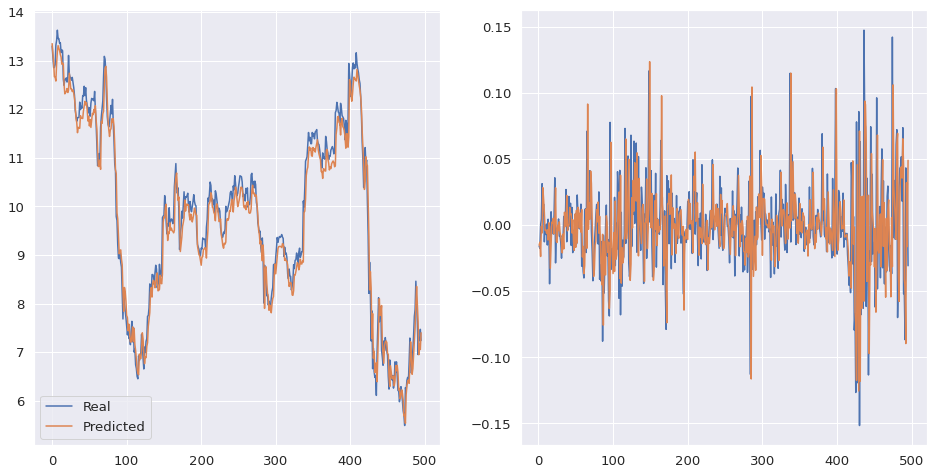

In [11]:
start = 0
end = -1
fig, axs = plt.subplots(1,2)

axs[0].plot(unscaled_y_test[start:end], label='real')
axs[0].plot(y_test_predicted[start:end], label='predicted')
axs[0].legend(['Real', 'Predicted'])


axs[1].plot(result[start:end]['sig_real'], label='real')
axs[1].plot(result[start:end]['sig_pred'], label='predicted')
axs[0].legend(['Real', 'Predicted'])
plt.show()


In [40]:
predicted_prices = get_price_prediction()
open_prices, long_balances, long_labels, _ = calculate_earning(predicted_prices, use_short=False, start=0, end=-1, verbose=1)
_, long_short_balances, long_short_labels,  _ = calculate_earning(predicted_prices, use_short=True, start=0, end=-1, verbose=1)

Short Trading:0, Profit:182.16 Base:-42.86 Period:[0, -1] Lost: 19.56
Short Trading:1, Profit:946.11 Base:-42.86 Period:[0, -1] Lost: 39.52


In [41]:
long_profits = []
long_short_profits = []
time_span = 64
for i in tqdm(range(0, unscaled_y_test.shape[0] - time_span)):
    _, _, _, long_profit = calculate_earning(predicted_prices, use_short=False, start=i, end=i+time_span)
    _, _, _, long_short_profit = calculate_earning(predicted_prices, use_short=True, start=i, end=i+time_span)
    long_profits.append(long_profit)
    long_short_profits.append(long_short_profit)


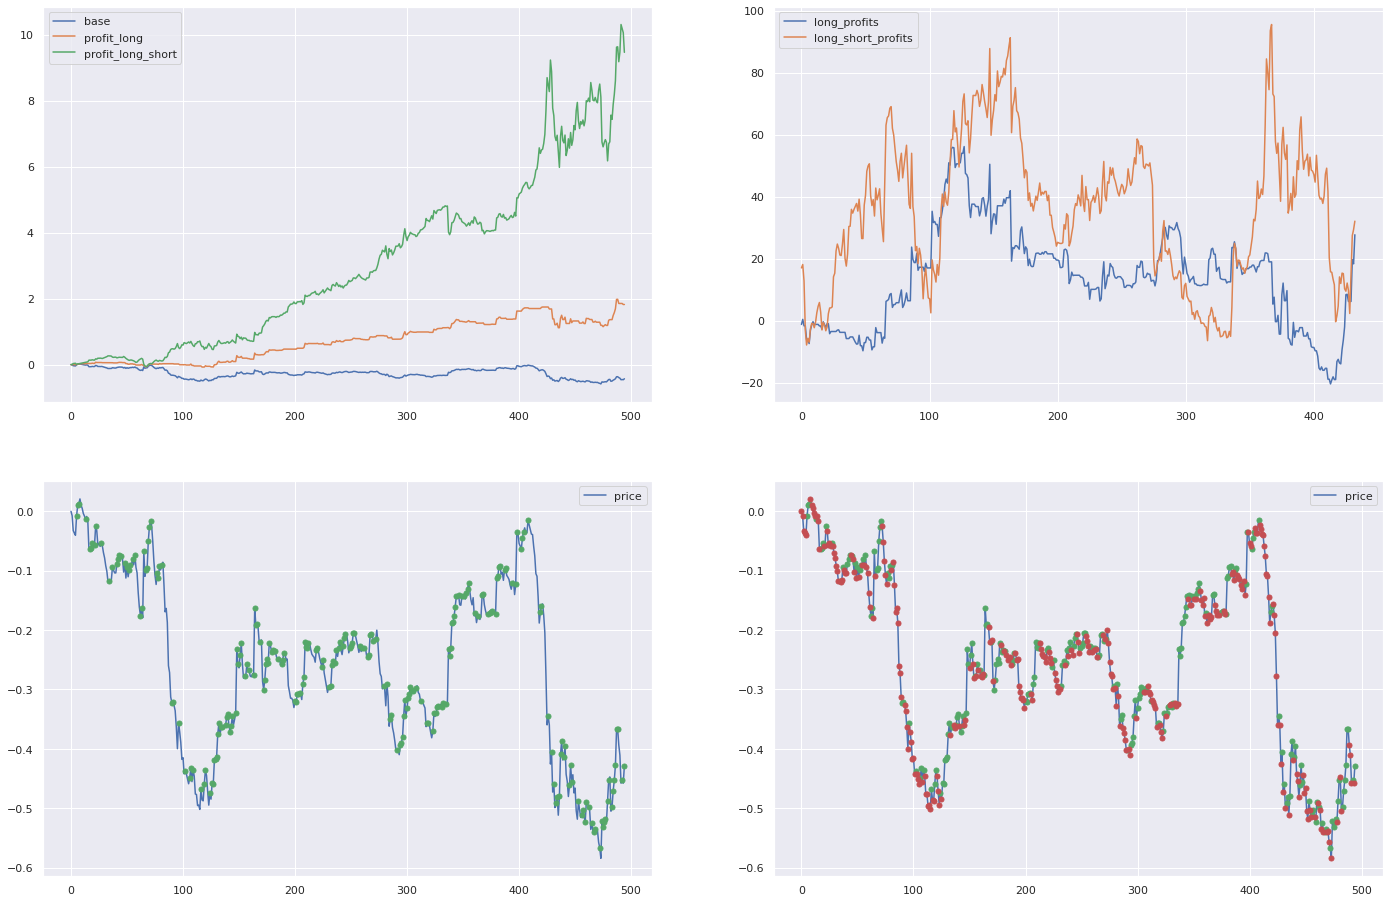

,profit_long,profit_long_short
count,433.000000,433.000000
mean,13.705033,35.413745
std,15.893529,22.944744
min,-20.378649,-7.825749
25%,-0.974510,17.347113
50%,14.190850,37.807616
75%,21.670077,49.892151
max,56.141321,95.491496


In [42]:
portfolio = pd.DataFrame(np.vstack((open_prices, long_balances, long_short_balances)).T,
                      columns=['base', 'profit_long', 'profit_long_short'])
portfolio /= portfolio.iloc[0]
portfolio -= 1
portfolio['signal_long'] = np.array(long_labels)
portfolio['signal_long_short'] = np.array(long_short_labels)

profit_df = pd.DataFrame(np.vstack((long_profits, long_short_profits)).T,
                      columns=['profit_long', 'profit_long_short'])

sns.set(rc={'figure.figsize':(24,16)})
fig, axs = plt.subplots(2,2)
axs[0][0].plot(portfolio.base, label='base')
axs[0][0].plot(portfolio.profit_long, label='profit_long')
axs[0][0].plot(portfolio.profit_long_short, label='profit_long_short')
axs[0][0].legend()

axs[0][1].plot(long_profits, label='long_profits')
axs[0][1].plot(long_short_profits, label='long_short_profits')
axs[0][1].legend()

axs[1][0].plot(portfolio.base, label='price')
# Plot the buy signals
axs[1][0].plot(portfolio.loc[portfolio.signal_long == 1].index, 
               portfolio.base[portfolio.signal_long == 1],
               'o', markersize=5, color='g')

axs[1][0].legend()

axs[1][1].plot(portfolio.base, label='price')
# Plot the buy signals
axs[1][1].plot(portfolio.loc[portfolio.signal_long_short == 1].index, 
               portfolio.base[portfolio.signal_long == 1],
               'o', markersize=5, color='g')
# Plot the buy signals
axs[1][1].plot(portfolio.loc[portfolio.signal_long_short == -1].index, 
               portfolio.base[portfolio.signal_long_short == -1],
               'o', markersize=5, color='r')
axs[1][1].legend()
plt.show()
sns.set(rc={'figure.figsize':(16,8)})

profit_df.describe()

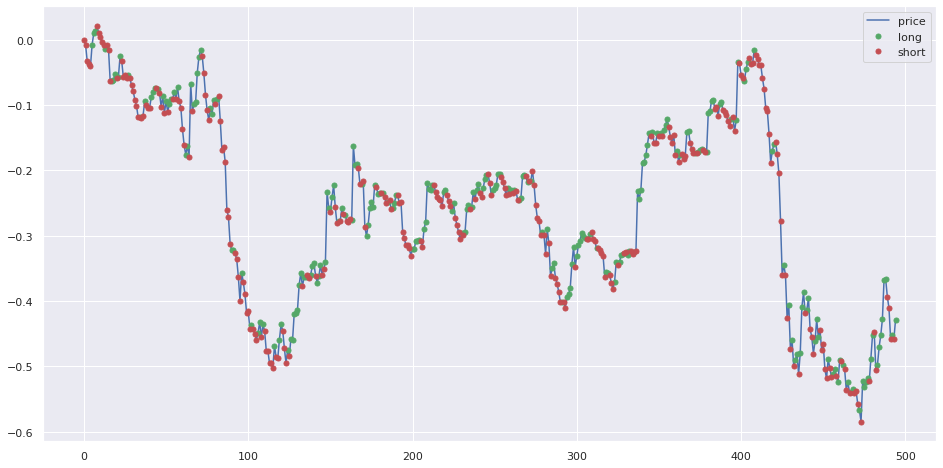

In [25]:
fig, axs = plt.subplots()

axs.plot(portfolio.base, label='price')
# Plot the buy signals
axs.plot(portfolio.loc[portfolio.signal_long_short == 1].index, 
               portfolio.base[portfolio.signal_long == 1],
               'o', markersize=5, color='g', label="long")
# Plot the buy signals
axs.plot(portfolio.loc[portfolio.signal_long_short == -1].index, 
               portfolio.base[portfolio.signal_long_short == -1],
               'o', markersize=5, color='r', label="short")
axs.legend()
plt.show()
